In [1]:
import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd

import os

# Database connection details from zshrc environment variables
db_name = 'colorado_spills'
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')


# Create an engine to connect to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db_name}')

# Function to load data from a table
def load_table(table_name):
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql(query, engine)
    return df

# Load the spills data
spills_df = load_table('spills')
spills_df.head()


,Document #,Report,Operator,Operator #,Tracking #,Initial Report Date,Date of Discovery,Spill Type,Qtr Qtr,Section,...,Soil Excavated,Offsite Disposal,Onsite Treatment,Other Disposition,Other Disposition Description,Ground Water Removed,Surface Water Removed,Corrective Actions Completed,Approved Form 27,Form 27 Project Number
0,400628833,I w/S,GREAT WESTERN OPERATING COMPANY LLC,10110,400628833,06/18/2014,06/11/2014,Historical,SESE,2,...,NaN,0.0,0.0,1.0,No work performed yet,NaN,NaN,False,NaN,2141471.0
1,400629910,I,COLORADO OIL & GAS CONSERVATION COMMISSION,5,400629910,06/19/2014,06/14/2014,Historical,NWNE,1,...,NaN,NaN,NaN,NaN,None,NaN,NaN,False,NaN,NaN
2,400629998,S,COLORADO OIL & GAS CONSERVATION COMMISSION,5,400629910,06/19/2014,06/14/2014,Historical,NWNE,1,...,200.0,1.0,0.0,0.0,None,0.0,0.0,True,NaN,NaN
3,400630821,I,KERR MCGEE GATHERING LLC,47121,400630821,06/20/2014,06/19/2014,Recent,NWNW,15,...,NaN,NaN,NaN,NaN,None,NaN,NaN,False,NaN,NaN
4,400631216,I,NOBLE ENERGY INC,100322,400631216,06/23/2014,06/20/2014,Recent,NENW,36,...,NaN,NaN,NaN,NaN,None,NaN,NaN,False,NaN,2141511.0


In [2]:
# Assuming you have a DataFrame named df
print(spills_df.columns.tolist())


['Document #', 'Report', 'Operator', 'Operator #', 'Tracking #', 'Initial Report Date', 'Date of Discovery', 'Spill Type', 'Qtr Qtr', 'Section', 'Township', 'range', 'meridian', 'Latitude', 'Longitude', 'Municipality', 'county', 'Facility Type', 'Facility ID', 'API County Code', 'API Sequence Number', 'Spilled outside of berms', 'More than five barrels spilled', 'Oil Spill Volume', 'Condensate Spill Volume', 'Flow Back Spill Volume', 'Produced Water Spill Volume', 'E&P Waste Spill Volume', 'Other Waste', 'Drilling Fluid Spill Volume', 'Current Land Use', 'Other Land Use', 'Weather Conditions', 'Surface Owner', 'Surface Owner Other', 'Waters of the State', 'Residence / Occupied Structure', 'livestock', 'Public Byway', 'Surface Water Supply Area', 'Spill Description', 'Supplemental Report Date', 'Oil BBLs Spilled', 'Oil BBLs Recovered', 'Oil Unknown', 'Condensate BBLs Spilled', 'Condensate BBLs Recovered', 'Condensate Unknown', 'Produced Water BBLs Spilled', 'Produced Water BBLs Recovere

Census tract data has been added to spills_df.
A plot of spills per tract has been generated.


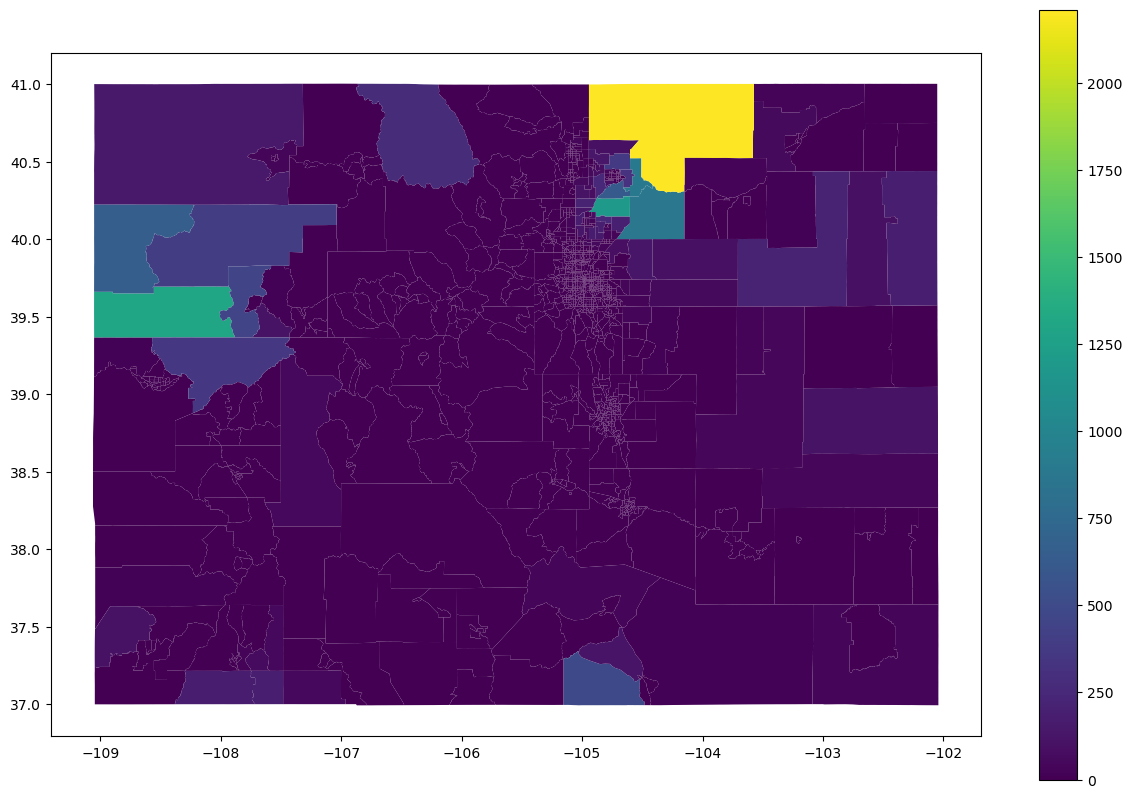

In [3]:
import geopandas as gpd
import pandas as pd
import us
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import shutil

# Convert spills_df to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    spills_df, 
    geometry=gpd.points_from_xy(spills_df.Longitude, spills_df.Latitude),
    crs="EPSG:4326"
)

# Get Colorado's FIPS code
colorado_fips = us.states.CO.fips

# Create a temporary directory for the shapefiles
temp_dir = "colorado_tracts_temp"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

try:
    # Download Colorado tract shapefile
    url = f"https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_{colorado_fips}_tract.zip"
    r = requests.get(url)
    z = ZipFile(BytesIO(r.content))
    z.extractall(temp_dir)

    # Find the .shp file in the extracted contents
    shp_file = next(f for f in os.listdir(temp_dir) if f.endswith('.shp'))
    
    # Read the shapefile
    tracts = gpd.read_file(os.path.join(temp_dir, shp_file))
    tracts = tracts.to_crs(gdf.crs)

    # Perform spatial join
    result = gpd.sjoin(gdf, tracts, how="left", predicate="within")

    # Add census tract information to the original DataFrame
    spills_df['GEOID'] = result['GEOID']
    spills_df['TRACT_NAME'] = result['NAME']

    # Count spills per census tract
    spills_per_tract = spills_df.groupby('GEOID').size().reset_index(name='spill_count')
    tracts_with_spills = tracts.merge(spills_per_tract, on='GEOID', how='left')
    tracts_with_spills['spill_count'] = tracts_with_spills['spill_count'].fillna(0)

    # Basic plot
    tracts_with_spills.plot(column='spill_count', legend=True, figsize=(15, 10))

finally:
    # Clean up: remove the temporary directory
    shutil.rmtree(temp_dir, ignore_errors=True)

print("Census tract data has been added to spills_df.")
print("A plot of spills per tract has been generated.")

In [4]:
import pandas as pd
import geopandas as gpd
import requests
from census import Census
from us import states

import os

# census API key from zshrc environment variable

c = Census(os.getenv('CENSUS_API_KEY'))

# Get unique GEOIDs from your spills data
unique_geoids = spills_df['GEOID'].unique()

# Function to get state and county FIPS codes from GEOID
def get_state_county(geoid):
    return geoid[:2], geoid[2:5]

# Prepare list of unique state and county codes
state_counties = list(set([get_state_county(geoid) for geoid in unique_geoids]))

# List of variables to fetch (you can modify this based on your specific needs)
variables = [
    'B01003_001E',  # Total Population
    'B02001_002E',  # White Population
    'B03002_012E',  # Hispanic or Latino Population
    'B19013_001E',  # Median Household Income
    'B17001_002E',  # Population for whom poverty status is determined
    'B23025_005E',  # Unemployed Population
]

# Fetch ACS data
acs_data = []
for state, county in state_counties:
    acs_data.extend(c.acs5.state_county_tract(
        variables,
        state,
        county,
        Census.ALL,
        year=2021
    ))

# Convert to DataFrame
acs_df = pd.DataFrame(acs_data)

# Rename columns
acs_df = acs_df.rename(columns={
    'B01003_001E': 'total_population',
    'B02001_002E': 'white_population',
    'B03002_012E': 'hispanic_population',
    'B19013_001E': 'median_household_income',
    'B17001_002E': 'poverty_population',
    'B23025_005E': 'unemployed_population'
})

# Calculate percentages and rates
acs_df['percent_white'] = acs_df['white_population'] / acs_df['total_population'] * 100
acs_df['percent_hispanic'] = acs_df['hispanic_population'] / acs_df['total_population'] * 100
acs_df['percent_poverty'] = acs_df['poverty_population'] / acs_df['total_population'] * 100
acs_df['unemployment_rate'] = acs_df['unemployed_population'] / acs_df['total_population'] * 100

# Create GEOID column
acs_df['GEOID'] = acs_df['state'] + acs_df['county'] + acs_df['tract']

# Merge ACS data with spills data
spills_ej_df = spills_df.merge(acs_df, on='GEOID', how='left')

# Aggregate spills data by census tract
spills_by_tract = spills_ej_df.groupby('GEOID').agg({
    'total_population': 'first',
    'percent_white': 'first',
    'percent_hispanic': 'first',
    'median_household_income': 'first',
    'percent_poverty': 'first',
    'unemployment_rate': 'first',
    'Document #': 'count'  # Assuming this is a unique identifier for each spill
}).reset_index()

spills_by_tract = spills_by_tract.rename(columns={'Document #': 'spill_count'})

print(spills_by_tract.head())

# You can now use spills_by_tract for further analysis and visualization

         GEOID  total_population  percent_white  percent_hispanic  \
0  08001008354            4211.0      28.591783         23.557350   
1  08001008401            5491.0      86.814788         14.059370   
2  08001008402            4974.0      82.046643         14.053076   
3  08001008526            7366.0      79.011675         16.806951   
4  08001008538           10456.0      75.181714         30.174063   

   median_household_income  percent_poverty  unemployment_rate  spill_count  
0                 101250.0        10.757540           0.379957           31  
1                  88286.0         5.918776           1.456930          122  
2                 114276.0         4.121431           2.211500           95  
3                  98283.0         3.801249           2.104263            1  
4                 131231.0         4.150727           3.471691            9  


In [5]:
spills_by_tract.shape

(158, 8)

In [14]:
# Assuming you have already fetched the ACS data as described earlier
# and it's stored in a DataFrame called acs_df

# Create GEOID column in acs_df if not already present
acs_df['GEOID'] = acs_df['state'] + acs_df['county'] + acs_df['tract']

# Select the columns we want to keep from acs_df
acs_columns = [
    'GEOID', 'total_population', 'white_population', 'hispanic_population',
    'median_household_income', 'poverty_population', 'unemployed_population',
    'percent_white', 'percent_hispanic', 'percent_poverty', 'unemployment_rate'
]

# Merge the ACS data with the spills data
spills_with_demographics = spills_df.merge(acs_df[acs_columns], on='GEOID', how='left')

# Check the result
print(f"Original spills_df shape: {spills_df.shape}")
print(f"spills_with_demographics shape: {spills_with_demographics.shape}")
print(spills_with_demographics.head())

# Check for any spills that didn't get matched with demographic data
unmatched = spills_with_demographics[spills_with_demographics['total_population'].isna()]
print(f"Number of spills without matched demographic data: {len(unmatched)}")

Original spills_df shape: (16890, 108)
spills_with_demographics shape: (16890, 118)
   Document # Report                                    Operator  Operator #  \
0   400628833  I w/S         GREAT WESTERN OPERATING COMPANY LLC       10110   
1   400629910      I  COLORADO OIL & GAS CONSERVATION COMMISSION           5   
2   400629998      S  COLORADO OIL & GAS CONSERVATION COMMISSION           5   
3   400630821      I                    KERR MCGEE GATHERING LLC       47121   
4   400631216      I                            NOBLE ENERGY INC      100322   

   Tracking # Initial Report Date Date of Discovery  Spill Type Qtr Qtr  \
0   400628833          06/18/2014        06/11/2014  Historical  SESE     
1   400629910          06/19/2014        06/14/2014  Historical  NWNE     
2   400629910          06/19/2014        06/14/2014  Historical  NWNE     
3   400630821          06/20/2014        06/19/2014      Recent  NWNW     
4   400631216          06/23/2014        06/20/2014      Rec

In [15]:
# save spills_with_demographics to a new table in the database

# Save the DataFrame to a new table in the database
spills_with_demographics.to_sql('spills_with_demographics', engine, if_exists='replace', index=False)

print("spills_with_demographics has been saved to the database.")



spills_with_demographics has been saved to the database.


In [16]:
# create csv file
spills_with_demographics.to_csv('spills_with_demographics.csv', index=False)

print("spills_with_demographics has been saved to a CSV file.")


spills_with_demographics has been saved to a CSV file.
